# SYDE 556/750: Simulating Neurobiological Systems

Accompanying Readings: Chapter 7

## Project Topics!
- Should be approved by now. If not, do it today.
- Can use your own code or Nengo.
- Questions?

## Decoder Analysis

- What functions $f(x)$ can we accurately compute from a group of neurons?
- Examples:

$f(x)=x$

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


RMSE 0.0115360799447


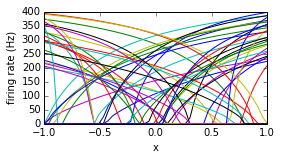

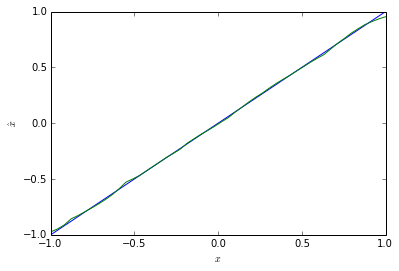

In [19]:
import nengo
from nengo.utils.ensemble import tuning_curves

model = nengo.Network(label='Neurons')
with model:
    neurons = nengo.Ensemble(50, dimensions=1) 
    
    connection = nengo.Connection(neurons, neurons) #This is just to generate the decoders
    
sim = nengo.Simulator(model)

d = sim.data[connection].weights.T
x, A = tuning_curves(neurons, sim)
xhat = numpy.dot(A, 1*d)

x= 1*x
figure(figsize=(4,2))
plot(x, A)
xlabel('x')
ylabel('firing rate (Hz)')

figure()
plot(x, x)
plot(x, xhat)
xlabel('$x$')
ylabel('$\hat{x}$')

print 'RMSE', np.sqrt(np.average((x-xhat)**2))

- What about $f(x)=10x$?  or larger numbers?

- How about $f(x)=x^2$

RMSE 0.0281040639739


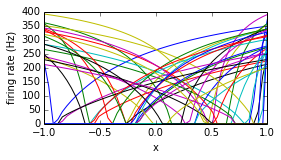

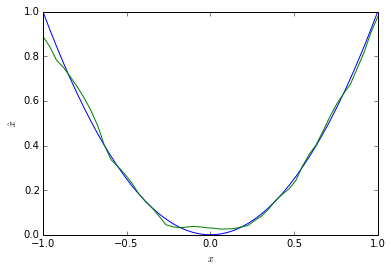

In [29]:
exponent = 2

with model:
    power_conn = nengo.Connection(neurons, neurons, function=lambda x: x**exponent)

sim = nengo.Simulator(model)

d = sim.data[power_conn].weights.T
x, A = tuning_curves(neurons, sim)
xhat = numpy.dot(A, d)

ideal = x**exponent

figure(figsize=(4,2))
plot(x, A)
xlabel('x')
ylabel('firing rate (Hz)')

figure()
plot(x, ideal)
plot(x, xhat)
xlabel('$x$')
ylabel('$\hat{x}$')

print 'RMSE', np.sqrt(np.average((ideal-xhat)**2))    

- Other exponents?  
    - $f(x)=x^3$
    - $f(x)=x^4$
    - $f(x)=x^5$
    - $f(x)=x^0$
    
- Polynomials?
    - If it's fairly good at $f(x)=2x$ and fairly good at $f(x)=x^2$, what happens with $f(x)=x^2+2x$?

- Other functions?
    - A Gaussian?
    - $f(x)=e^{- (x-b)^2/(2c^2)}$


RMSE 0.023140704508


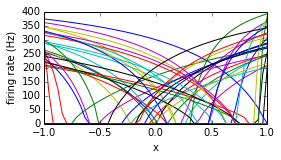

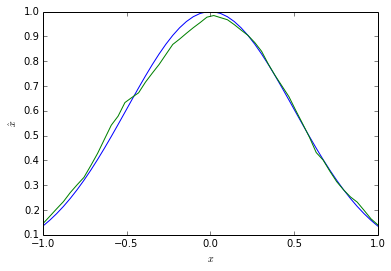

In [33]:
c = .5
b = 0

with model:
    exp_conn = nengo.Connection(neurons, neurons, function=lambda x: np.exp(-(x-b)**2/(2*c**2)))
    
sim = nengo.Simulator(model)

d = sim.data[exp_conn].weights.T
x, A = tuning_curves(neurons, sim)
xhat = numpy.dot(A, d)

ideal = np.exp(-(x-b)**2/(2*c**2))

figure(figsize=(4,2))
plot(x, A)
xlabel('x')
ylabel('firing rate (Hz)')

figure()
plot(x, ideal)
plot(x, xhat)
xlabel('$x$')
ylabel('$\hat{x}$')

print 'RMSE', np.sqrt(np.average((ideal-xhat)**2))        

- What about different values of $c$?

##Linear algebra review

###Orthonormal basis
<img src="files/lecture6/cartesian.png">
- The standard Cartesian basis in any number of dimensions is comprised of the unit vectors along the principle axes
    - The vectors in this basis are orthogonal, i.e., the dot product of any two will be zero; 
    - $x \cdot y = \langle xy \rangle_n = \sum_n x[n]y[n] = 0$
- If all the vectors in a basis are orthogonal, it is called an orthogonal basis
- If the length of all the vectors in an orthogonal basis is equal to one then it is an orthonormal basis

#### Orthogonal Example
<img src="files/lecture6/rotate.png">
- Let the vector x be written in a standard Cartesian basis 
    - $x = [x_1, x_2] = x_1 i + x_2 j$
- Suppose we have a different basis, rotated by 45 degrees ($d_1, d_2$)
    - ‘Encoding’: $a_i=\langle x d_i \rangle_n$
    - Projection onto the new basis: $a = [a_1,a_2] = a_1 d_1 + a_2 d_2$
    - ‘Decoding': $x = \sum_i a_i d_i$

-  This way, we can move back and forth between orthonormal bases

- Notice that if we substitute the encoding into the decoding, we recover the same vector we originally encoded

- Thus we can think of the coefficients $a_i$ as ‘representing’, or ‘carrying the same information’, or ‘encoding’ the original coefficients $x_i$

###Overcomplete basis
- If we relax the constraint that the vectors have to be independent, we have what is called an overcomplete basis (or sometimes `frame'). 
    - Overcomplete bases are redundant (hence not as succinct) for defining the vector space
    - In noisy, physical systems, this redundancy can prove invaluable for error correction and the efficient use of available resources
    
#### Overcomplete Example
<img src="files/lecture6/overcomplete.png">
- Suppose we do not know what the decoding basis is, but we know the encoding basis
- We can guarantee that the encoding basis is overcomplete by using redundant, non-orthogonal encoders
    - Let’s choose the encoding basis as equally spaced at 120 degree intervals (see picture)
- We need to identify the set of vectors that span the space into which our vector is being encoded (i.e., the decoding basis). 
    - To find this basis, we first note, as before, that
    - $x = \sum_i a_i d_i$
    - $a_i = \langle x e_i \rangle$
- Substitute the encoding into decoding to give:
    - $x = \sum_i \langle x e_i \rangle d_i$
- Writing the dot product explicitly, we get x 
    - $x = \sum_{i,n,m} x[n] e_i[n] d_i[m] = \sum_{n,m} x[n] \sum_i e_i[n] d_i[m]$
- So,
    - $\delta_{nm} = \sum_i e_i[n] d_i[m]$
- In matrix notation:
    - $I = e d$
- Solving for the decoders
    - $I = e d$
    - $e^T = e^T e d$
    - $d = (e^T e)^-1 e^T$
- Calculating for this example gives 
    - $d_i = \frac{2}{3} e_i$

<img src="files/lecture6/overcomplete_decode.png">

- The $d_i$ are an overcomplete basis for the vector space in which the $a_i$ are coordinates. 
    - and hence are the decoding vectors defining the representation 
    - (and this explains why Georgopolous' idea of using encoders as decoders works fairly well)
- A set of encoders/decoders like this is called biorthogonal because together they act as an orthogonal basis. 
- Technically, the NEF encoders/decoders don’t satisfy the definitions provide here, but they are close 

###Basis functions
- Applies equally to basis _functions_
- Just as basis vectors define a vector space, so basis functions define a function space 
    - E.g. sines and cosines for a Fourier decomposition. This is an orthonormal basis. 
- Can have overcomplete basis functions as well
    - The tuning curves are like a set of overcomplete basis functions for the space they represent
    - The space they represent is the space you can compute well from that population
    - What is that space?

## The Decoder Calculation

- What are decoders good at?
- How do we compute decoders?
    - Here's the simple noise-free case:
    - $\Gamma=A^T A$ and $\Upsilon=A^T f(x)$
    - $ d = \Gamma^{-1} \Upsilon $    
- Consider the $\Gamma$ matrix
    - This is known as a Gram matrix
    - Measure of similarity of neural responses (correlation matrix)
    - Tells us about the representation of the vector space by the neurons
- Stepping through the decoder calculation:
    - ideally, $X = A d$
    - $A^T X = A^T A d$
    - $(A^T A)^{-1} A^T X = d$
- So our estimate is:
    - $\hat{X} = A (A^T A)^{-1} A^T X$
- How do we take the inverse correctly?
    - This is likely to be a singular matrix (lots of neurons have similar tuning curves)
    - Less of an issue normally, since we take noise into account and add onto the diagonal
    - Instead, let's do SVD to decompose and approximately invert the matrix
- Singular Value Decomposition
     - In general, 
         - $B_{M,N}=U_{M,M} S_{M,N} V^T_{N,N}$ 
         - where $S$ is a diagonal matrix of singular values
     - But here, $\Gamma$ is square and symmetric, so $\Gamma=U S U^T$ and the inverse of $\Gamma$ can be written as 
         - $\Gamma^{-1}=U S^{-1} U^T$
     - This is closely related to the eigenvalue decomposition of $A$.  
         - Specifically, $U$ are the eigenvectors of $A$ and singular values of $\Gamma$ are the square of the eigenvalues of $A$.
     - When $\Gamma$ is singular (or nearly so), then some elements of the diagonal of $S$ are zero (or very small), so the inverse has values that are infinite (or very large)
     - The "Pseudo-inverse" is to say if $S_i=0$, then $S^{-1}_i=0$... infinity equals zero
     - This gives a reasonable solution to singular matrices

<img src="files/lecture6/svd.png">

- When a vector in $\Upsilon$ lies outside the range of $\Gamma$, the SVD pseudo-inverse guarantees that the best (in the least squares sense) $d$ given $\Upsilon$ is found. 
    - I.e., this `pseudo-inverse' minimizes the error. Thus, we can use SVD to find the optimal decoders

### Usefulness of SVD
- Regardless of the function we want to decode, we always invert the same $\Gamma$ matrix
    - Identity decoder is just the special case $f(x)=x$
    - Understanding properties of $\Gamma$ can provide insight into all possible linear decodings from the populations's activity $A$

- The vectors in $U$ are orthogonal
    - They are an ordered, orthogonal basis
    - The original $\Gamma$ matrix was generated by a non-ordered, non-orthogonal basis: the neuron tuning curves

- Consider the neural activity for a particular $x$ value
    - A row of the $A$ matrix
    - The "activity space" of the neurons
        - i.e., $a = a_1 e_1 + a_2 e_2 + ... + a_N e_N$
        - Here, $e_i$ are axis vectors, one for each neuron with activity $a_i$. 
    - Because the neural responses are non-independently driven by some variable $x$, only a small part of the subspace of possible neural activity values is ever reached by the population
- The $\Gamma$ matrix, because it tells us the correlations between all neurons in the population, provides the information needed to determine that subspace
- That subspace is spanned by the $U$ vectors
- Recall:
    - $\hat{X} = A (A^T A)^{-1} A^T X$
    - $\hat{X} = A U S^{-1} U^T A^T X$
- Define:
    - $\hat{X} = \chi \Phi$
    - $\chi = AU$
        - i.e., $\chi_m(x) = \sum_i a_i(x) U_{im}$
    - $\Phi = S^{-1} U^T A^T X$
    - $\Phi = U^T U S^{-1} U^T A^T X$
    - $\Phi = U^T d$
        - i.e., $\Phi_m = \sum_i U_{mi} d_i$
- Notice that $\chi$ and $\Phi$ are rotated versions of $A$ and $d$ respectively. 
    - They are rotated into the coordinate system defined by $U$.  
- We can think of $U$ as the rotation matrix that 
    - Aligns the first axis of the coordinate system along the dimension with the greatest variance in the encoding of $x$, 
    - Aligns the second axis along the dimension with the second greatest variance, etc.
- So the $\chi$ vectors also end up being orthogonal and ordered by importance
- _So they are basis functions for the function space computable from $A$_
    
<img src="files/lecture6/svd_projection.png">
    
- The singular values $S$ tell us the "importance" of a particular $U$ vector, including:
    - The error if that $U$ vector was left out of the reconstruction of $Gamma$
    - The amount the variance of the population firing in that direction
    - The amount of independent information about the population firing that could be extracted if we were only looking at the data projected onto that $U$ vector.
- In general, we can think of the magnitude of the singular value as telling us how relevant that $U$ vector is to the identity of the matrix we have decomposed
    - Since the matrix we have decomposed is like the correlation matrix of the neuron tuning curves, the large singular values are the most important for accounting for the structure of those correlations in the population

- So what?
    - So, let's rotate our neural activity curves $A$ into this subspace and see what they look like.
    - $\chi = A U$
    - These will be the orthogonal functions we can decode, ordered by accuracy
    

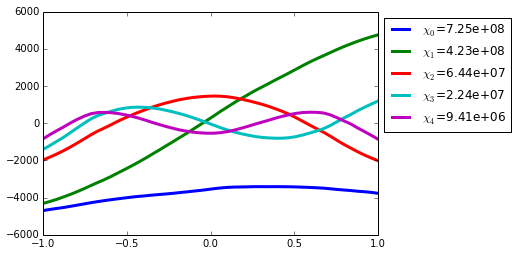

In [13]:
import nengo
from nengo.utils.ensemble import tuning_curves

model = nengo.Network(label='Neurons')
with model:
    neurons = nengo.Ensemble(1000, dimensions=1) 
    
    connection = nengo.Connection(neurons, neurons) #This is just to generate the decoders
    
sim = nengo.Simulator(model)

d = sim.data[connection].weights.T
x, A = tuning_curves(neurons, sim)
xhat = numpy.dot(A, d)

Gamma = np.dot(A.T, A)
U,S,V = np.linalg.svd(Gamma)

chi = np.dot(A, U)

for i in range(5):
    plot(x, chi[:,i], label='$\chi_%d$=%1.3g'%(i, S[i]), linewidth=3)
legend(loc='best', bbox_to_anchor=(1,1))    
show()

- Does anybody recognize those functions?

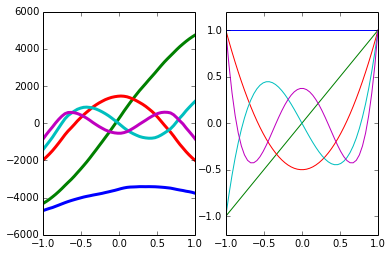

In [14]:
subplot(1,2,1)
for i in range(5):
    plot(x, chi[:,i], linewidth=3)

subplot(1,2,2)
for i in range(5):
    plot(x, numpy.polynomial.legendre.legval(x, numpy.eye(10)[i]))
ylim(-1.2,1.2)
show()

- The [Legendre polynomials](http://en.wikipedia.org/wiki/Legendre_polynomials)
    - Or at least scaled (and maybe flipped) version thereof
- So we should be able to approximate any function that can be approximated by polynomials    
- But remember that they are ordered by their singular values
- See how quickly the singular values drop off:

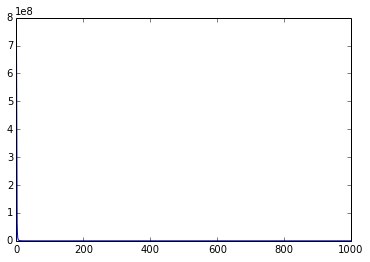

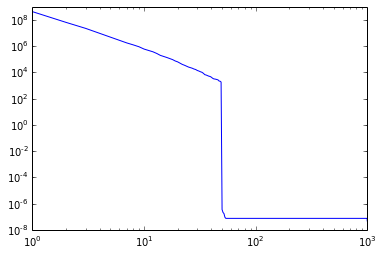

In [15]:
plot(S)

figure()
loglog(S)

- If you need higher and higher polynomials, you need many more neurons

### Modifying that basis

- Are we stuck with this?
- What can we do to modify these basis functions?


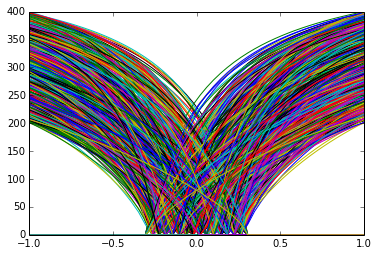

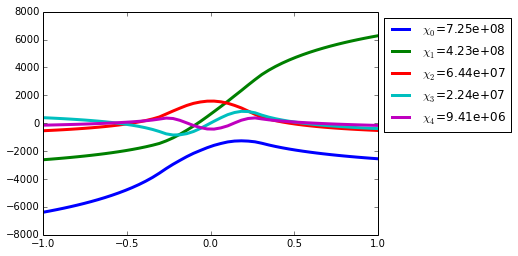

In [16]:
import nengo
from nengo.utils.ensemble import tuning_curves
from nengo.dists import Uniform

model = nengo.Network(label='Neurons')
with model:
    neurons = nengo.Ensemble(1000, dimensions=1, intercepts=Uniform(-.3,.3)) 
    
    connection = nengo.Connection(neurons, neurons) #This is just to generate the decoders
    
sim = nengo.Simulator(model)

d = sim.data[connection].weights.T
x, A = tuning_curves(neurons, sim)
xhat = numpy.dot(A, d)

Gamma = np.dot(A.T, A)
U,S1,V = np.linalg.svd(Gamma)

chi = np.dot(A, U)

figure()
plot(x,A)

figure()
for i in range(5):
    plot(x, chi[:,i], label='$\chi_%d$=%1.3g'%(i, S[i]), linewidth=3)
legend(loc='best', bbox_to_anchor=(1,1))    
show()

- What about other distributions of intercepts?
- Changing these distributions also affects how much it gets better with more neurons

<img src="files/lecture6/tuning_curve_error.png">

- Note that the accuracy curves are for $f(x)=x$

- What about different shapes of tuning curves altogether?
    - How about 'cosine tuning' (recall Georgopolous' experiments)

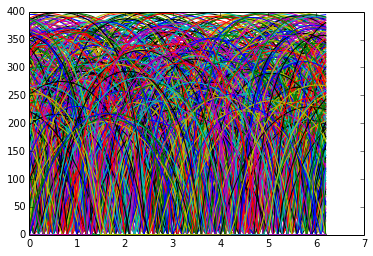

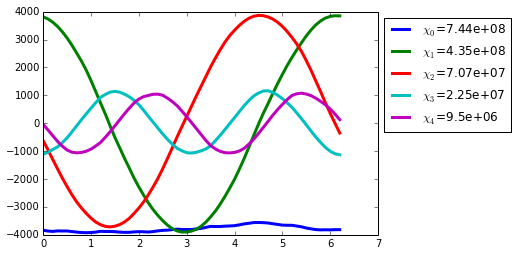

In [8]:
import nengo
from nengo.utils.ensemble import tuning_curves
from nengo.dists import Uniform

model = nengo.Network(label='Neurons')
with model:
    neurons = nengo.Ensemble(1000, dimensions=2, intercepts=Uniform(-.3,.3)) 
    
    connection = nengo.Connection(neurons, neurons) #This is just to generate the decoders
    
sim = nengo.Simulator(model)

d = sim.data[connection].weights.T
theta = np.arange(0,2*np.pi,.1)
x = np.array([np.sin(theta), np.cos(theta)]).T
A = neurons.neuron_type.rates(np.dot(x, sim.data[neurons].encoders.T),
        sim.data[neurons].gain, sim.data[neurons].bias)

Gamma = np.dot(A.T, A)
U,S2,V = np.linalg.svd(Gamma)

chi = np.dot(A, U)

figure()
plot(theta, A)

figure()
for i in range(5):
    plot(theta, chi[:,i], label='$\chi_%d$=%1.3g'%(i, S[i]), linewidth=3)
legend(loc='best', bbox_to_anchor=(1,1));

- Look familiar?  
- How will it be better/worse than broader curves?
- Here's a hint...

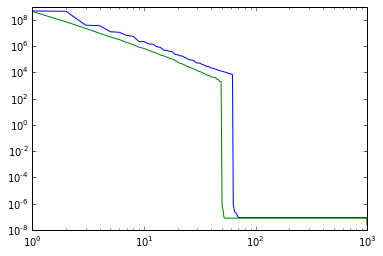

In [9]:
loglog(S2)
loglog(S)

You can see these come more in pairs, and seem to be a bit higher.  Most importantly, the functions being combined (i.e. basis functions) are quite different.

## Higher dimensions

- Does this apply to vectors as well as scalars?
    - Of course
    - Same math, even
    - Just a little harder to plot

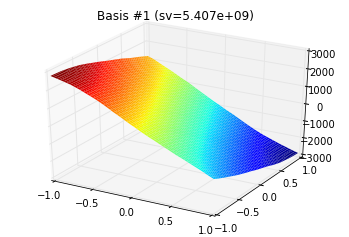

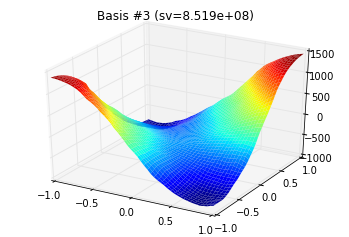

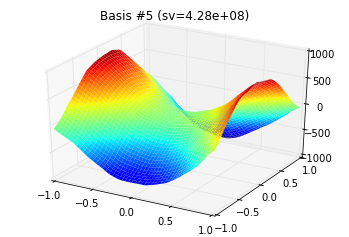

In [10]:
import nengo
from nengo.utils.ensemble import tuning_curves
from nengo.dists import Uniform

N = 500

model = nengo.Network(label='Neurons', seed=2)
with model:
    neurons = nengo.Ensemble(N, dimensions=2) 
    
    connection = nengo.Connection(neurons, neurons) #This is just to generate the decoders
    
sim = nengo.Simulator(model)

d = sim.data[connection].weights.T
x, A = tuning_curves(neurons, sim)

A = np.reshape(A, (2500,N))
               
Gamma = np.dot(A.T, A)
U,S,V = np.linalg.svd(Gamma)

chi = np.dot(A, U)

for index in [1,3,5]: #What's 0? 3,4,5 (same/diff signs, cross)? Higher?
    basis = chi[:,index]
    basis.shape = 50,50

    x0 = numpy.linspace(-1,1,50)
    x1 = numpy.linspace(-1,1,50)
    x0, x1 = numpy.array(meshgrid(x0,x1))

    from mpl_toolkits.mplot3d.axes3d import Axes3D
    fig = pylab.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    p = ax.plot_surface(x0, x1, basis, linewidth=0, cstride=1, rstride=1, cmap=pylab.cm.jet)
    pylab.title('Basis #%d (sv=%1.4g)'%(index, S[index]))


- Again, we get the polynomials
- In general, we get cross-terms in the computable functions
- For the 2D case:
    - $f(x)=a_0 + a_1 x_0 + a_2 x_1 + a_3 (x_0^2 + x_1^2) + a_4(x_0^2 - x_1^2) + a_5 x_0 x_1 + ...$
    
<img src="files/lecture6/multidim_sv.png">

- The grey line is constant for as many terms as should be at about the same accuracy level
- In higher dimensions, higher order functions are even harder

- This is all also going to be affected by distributions of encoders (as well as distributions of intercepts and maximum rates)

###Final thoughts
- Given a function, can we automatically find good choices for tuning curves?
    - In general, this is a difficult problem
    - Indeed, we can cast this as exactly the standard multi-layer neural network learning problem
    - But analyzing it this way gives us hints
- General techniques
    - If your function has a big zero area, see if you can get the tuning curves to also be zero in that area
    - Smooth, broad functions are best
    - E.g., for the important case of $f(x)=x_0 x_1$, arrange your encoders at $[1,1], [1,-1], [-1,-1], [-1, 1]$
    